In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from gensim.models import Word2Vec
import gensim
from scipy.sparse import csr_matrix
from libreco.algorithms import ItemCF
from libreco.data import DatasetPure
from libreco.evaluation import evaluate
import tensorflow as tf


In [2]:

# Load DataFrames
books = pd.read_csv('data/books.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
book_tags = pd.read_csv('data/book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices





C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:49:43
Final block size and num: (7834, 1)
sim_matrix elapsed: 1.625s
sim_matrix, shape: (7834, 7834), num_elements: 11293474, density: 39.5749 %


eval_pointwise:   0%|          | 0/14 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 28 and item 244, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 479, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 2971, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 794, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 455, proceed with default prediction
No common interaction or similar neighbor for user 28 and item 8, proceed with default prediction


eval_pointwise: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


	 eval rmse: 1.0540
	 eval mae: 0.7945
	 eval r2: -0.1327


eval_pointwise: 100%|██████████| 14/14 [00:24<00:00,  1.77s/it]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:51:04
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.581s
sim_matrix, shape: (7834, 7834), num_elements: 688834, density: 2.4138 %


eval_pointwise:   0%|          | 0/57 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 13, proceed with default prediction


eval_pointwise: 100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


	 eval rmse: 1.0449


eval_pointwise: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:52:23
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.494s
sim_matrix, shape: (7834, 7834), num_elements: 678110, density: 2.3763 %


eval_pointwise:   0%|          | 0/57 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 185, proceed with default prediction


eval_pointwise: 100%|██████████| 57/57 [00:43<00:00,  1.31it/s]


	 eval rmse: 1.0989


eval_pointwise: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:54:00
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.547s
sim_matrix, shape: (7834, 7834), num_elements: 1578720, density: 5.5322 %


eval_pointwise:   0%|          | 0/52 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 7225, proceed with default prediction


eval_pointwise: 100%|██████████| 52/52 [00:52<00:00,  1.01s/it]


	 eval rmse: 1.1346


eval_pointwise: 100%|██████████| 52/52 [01:00<00:00,  1.17s/it]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:56:15
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.815s
sim_matrix, shape: (7834, 7834), num_elements: 1446082, density: 5.0674 %


eval_pointwise:   0%|          | 0/53 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 733, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 465, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction


eval_pointwise: 100%|██████████| 53/53 [01:02<00:00,  1.18s/it]


	 eval rmse: 1.1610


eval_pointwise: 100%|██████████| 53/53 [01:13<00:00,  1.39s/it]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 10:58:57
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.845s
sim_matrix, shape: (7834, 7834), num_elements: 963372, density: 3.3759 %


eval_pointwise:   0%|          | 0/55 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 4572, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 969, proceed with default prediction


eval_pointwise: 100%|██████████| 55/55 [01:27<00:00,  1.60s/it]


	 eval rmse: 1.3513


eval_pointwise: 100%|██████████| 55/55 [01:29<00:00,  1.63s/it]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 11:02:18
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.797s
sim_matrix, shape: (7834, 7834), num_elements: 1422724, density: 4.9855 %


eval_pointwise:   0%|          | 0/51 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 5149, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1754, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2439, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 5245, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3841, proceed with default prediction
No common interaction or similar neighbor for user 1 and item 3486, proceed with default prediction


eval_pointwise: 100%|██████████| 51/51 [01:19<00:00,  1.56s/it]


	 eval rmse: 1.4963


eval_pointwise: 100%|██████████| 51/51 [01:09<00:00,  1.36s/it]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 11:05:06
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.687s
sim_matrix, shape: (7834, 7834), num_elements: 1262400, density: 4.4237 %


eval_pointwise:   0%|          | 0/54 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3938, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 728, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 465, proceed with default prediction


eval_pointwise: 100%|██████████| 54/54 [00:38<00:00,  1.40it/s]


	 eval rmse: 1.4268


eval_pointwise: 100%|██████████| 54/54 [00:37<00:00,  1.43it/s]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 11:06:39
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.627s
sim_matrix, shape: (7834, 7834), num_elements: 898786, density: 3.1496 %


eval_pointwise:   0%|          | 0/56 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2406, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1316, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 452, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 5149, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 580, proceed with default prediction


eval_pointwise: 100%|██████████| 56/56 [00:49<00:00,  1.14it/s]


	 eval rmse: 1.7394


eval_pointwise: 100%|██████████| 56/56 [00:50<00:00,  1.11it/s]
C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


Training start time: 2024-06-05 11:08:35
Final block size and num: (7834, 1)
sim_matrix elapsed: 0.681s
sim_matrix, shape: (7834, 7834), num_elements: 1576178, density: 5.5233 %


eval_pointwise:   0%|          | 0/52 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 0 and item 2641, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 7225, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 1780, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 2439, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 969, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 3404, proceed with default prediction


eval_pointwise: 100%|██████████| 52/52 [00:55<00:00,  1.06s/it]


	 eval rmse: 1.7619


eval_pointwise: 100%|██████████| 52/52 [00:58<00:00,  1.12s/it]


Evaluation Results:
Strategy: percentage, Shot: N/A -> RMSE: 1.0539861187524306, MAE: 0.7945131695897745, R2: -0.13268499214312235
Strategy: random, Shot: 5 -> RMSE: 1.044919659373139, MAE: 0.7865129403609562, R2: -0.10417858502655286
Strategy: random, Shot: 10 -> RMSE: 1.0989339662173248, MAE: 0.8149226025567365, R2: -0.22332417092307488
Strategy: random, Shot: 20 -> RMSE: 1.1346193078123044, MAE: 0.8376664567738791, R2: -0.30539548742247336
Strategy: highest, Shot: 5 -> RMSE: 1.1610378964431154, MAE: 0.8470585097871917, R2: -0.3802461883175159
Strategy: highest, Shot: 10 -> RMSE: 1.3513243899272178, MAE: 1.0370586574942349, R2: -0.9046459198015355
Strategy: highest, Shot: 20 -> RMSE: 1.496263470840182, MAE: 1.186028908071214, R2: -1.4295537691731166
Strategy: lowest, Shot: 5 -> RMSE: 1.4267508937992799, MAE: 1.1324913469428382, R2: -1.5174522127537737
Strategy: lowest, Shot: 10 -> RMSE: 1.7393879163251191, MAE: 1.4592167203196749, R2: -3.310013774453882
Strategy: lowest, Shot: 20 -> 

In [ ]:
# Example usage of evaluation
strategies = ['percentage', 'random', 'highest', 'lowest']
shots = [5, 10, 20]
percentage = 0.2

results = {}


for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize the ItemCF model
        model = ItemCF(task="rating", data_info=data_info)

        # Fit the model
        model.fit(
            train_data,
            neg_sampling=False,
            verbose=2,
            eval_data=eval_data,
            metrics=["rmse", "mae", "r2"]
        )

        # Save the model and data_info for later use
        data_info.save(path="model", model_name="model")
        model.save(path="model", model_name="model", manual=True, inference_only=True)

        eval_result = evaluate(
            model=model,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )

        results[(strategy, 'N/A')] = eval_result

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize the ItemCF model
            model = ItemCF(task="rating", data_info=data_info)

            # Fit the model
            model.fit(
                train_data,
                neg_sampling=False,
                verbose=2,
                eval_data=eval_data
            )

            # Save the model and data_info for later use
            data_info.save(path="model", model_name="model")
            model.save(path="model", model_name="model", manual=True, inference_only=True)

            eval_result = evaluate(
                model=model,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )

            results[(strategy, shot)] = eval_result

print("Evaluation Results:")
for key, value in results.items():
    print(f"Strategy: {key[0]}, Shot: {key[1]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")


### Graph Analysis

In [42]:
B = nx.Graph()

B.add_nodes_from(ratings['user_id'], bipartite=0)
B.add_nodes_from(ratings['book_id'], bipartite=1)

edges = list(zip(ratings['user_id'], ratings['book_id'], ratings['rating']))
B.add_weighted_edges_from(edges)

# Verify edges and their attributes
for edge in list(B.edges(data=True))[:5]:  # Print first 5 edges with attributes
    print(edge)

(8, 2732, {'weight': 5})
(8, 1432, {'weight': 3})
(8, 479, {'weight': 4})
(8, 3020, {'weight': 5})
(8, 6195, {'weight': 4})


In [32]:
ratings['user_id'].nunique()

5342

In [33]:
ratings['book_id'].nunique()    

7834

In [43]:
n_edge = B.number_of_edges()
n_edge

529887

#### Reduce graph size 

In [37]:
def compute_cosine_similarity(graph, threshold):
    # Create adjacency matrix for users and books
    user_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 0]
    book_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 1]
    
    # Create adjacency matrices
    user_book_matrix = nx.bipartite.biadjacency_matrix(graph, row_order=user_nodes, column_order=book_nodes).toarray()
    
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(user_book_matrix)
    
    # Filter edges based on similarity threshold
    filtered_edges = []
    for i, user in enumerate(user_nodes):
        for j, book in enumerate(book_nodes):
            if similarity_matrix[i, j] >= threshold:
                if graph.has_edge(user, book):
                    filtered_edges.append((user, book, graph[user][book]['weight']))
    
    return filtered_edges

# Define similarity threshold
similarity_threshold = 0.5

# Compute filtered edges based on co-similarity
filtered_edges = compute_cosine_similarity(B, similarity_threshold)

# Create a new graph with the filtered edges
B_filtered = nx.Graph()
B_filtered.add_weighted_edges_from(filtered_edges)

# Calculate edge weights and their probabilities in the filtered graph
edge_weights = np.array([d['weight'] for u, v, d in B_filtered.edges(data=True)])
edge_probabilities = edge_weights / edge_weights.sum()

# Sampling edges with probabilities
num_edges_to_sample = min(100000, B_filtered.number_of_edges())
edges_list = list(B_filtered.edges(data=True))  # Convert edges to list for indexing
sampled_indices = np.random.choice(len(edges_list), size=num_edges_to_sample, replace=False, p=edge_probabilities)
sampled_edges = [edges_list[i] for i in sampled_indices]

# Create a new graph with the sampled edges
B_sampled = nx.Graph()
B_sampled.add_edges_from([(u, v, {'weight': d['weight']}) for u, v, d in sampled_edges])

print(f"Number of edges in the sampled graph: {B_sampled.number_of_edges()}")

for edge in list(B_sampled.edges(data=True))[:5]:
    print(edge)

#### other method 

In [44]:
edge_weights = np.array([d['weight'] for u, v, d in B.edges(data=True)])
edge_probabilities = edge_weights / edge_weights.sum()


num_edges_to_sample = min(100000, B.number_of_edges())
edges_list = list(B.edges(data=True)) 
sampled_indices = np.random.choice(len(edges_list), size=num_edges_to_sample, replace=False, p=edge_probabilities)
sampled_edges = [edges_list[i] for i in sampled_indices]


B_sampled = nx.Graph()
B_sampled.add_edges_from([(u, v, {'weight': d['weight']}) for u, v, d in sampled_edges])

print(f"Number of edges in the sampled graph: {B_sampled.number_of_edges()}")

for edge in list(B_sampled.edges(data=True))[:5]:
    print(edge)

Number of edges in the sampled graph: 100000
(12211, 1423, {'weight': 3})
(12211, 271, {'weight': 5})
(12211, 1993, {'weight': 4})
(12211, 2513, {'weight': 5})
(12211, 2347, {'weight': 3})


#### Metrics 

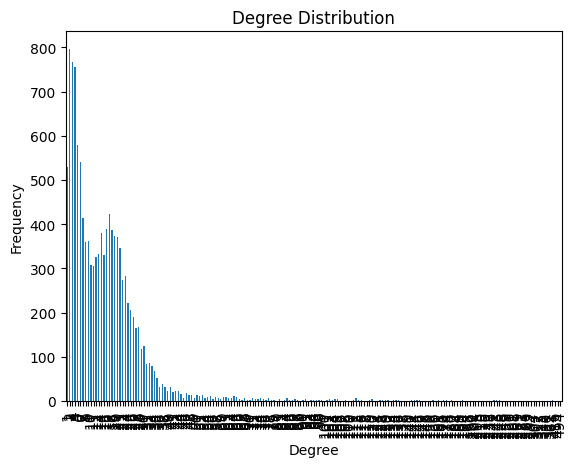

In [46]:
import matplotlib.pyplot as plt

degree_sequence = [d for n, d in B_sampled.degree()]
degree_count = pd.Series(degree_sequence).value_counts().sort_index()
plt.figure()
degree_count.plot(kind='bar')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [47]:
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree: {average_degree}")

Average Degree: 16.409583196586805


In [48]:
density = nx.density(B_sampled)
print(f"Density: {density}")


Density: 0.0013464825795180772


In [49]:
clustering_coefficient = nx.average_clustering(B_sampled)
print(f"Clustering Coefficient: {clustering_coefficient}")

Clustering Coefficient: 0.0014598601511071657


In [50]:
num_connected_components = nx.number_connected_components(B_sampled)
print(f"Number of Connected Components: {num_connected_components}")

Number of Connected Components: 1


In [51]:
assortativity = nx.degree_assortativity_coefficient(B_sampled)
print(f"Assortativity: {assortativity}")

Assortativity: -0.12341805759059894


In [52]:

local_clustering = nx.clustering(B_sampled)
local_clustering_avg = sum(local_clustering.values()) / len(local_clustering)
print(f"Average Local Clustering Coefficient: {local_clustering_avg}")

Average Local Clustering Coefficient: 0.0014598601511071657


### LibRecommender : GraphSage : Ranking 

In [53]:
# import torch
# import torch.nn.functional as F

# def custom_loss_function(user_embeddings, item_embeddings, labels, negative_samples):
#     # user_embeddings: N-dimensional vector representation of users
#     # item_embeddings: N-dimensional vector representation of items
#     # labels: ground truth labels for the items (1 for positive samples, 0 for negative samples)
#     # negative_samples: negative samples for the given users

#     # Positive sample loss
#     pos_scores = torch.sum(user_embeddings * item_embeddings, dim=1)
#     pos_loss = F.logsigmoid(pos_scores)

#     # Negative sample loss
#     neg_scores = torch.bmm(negative_samples, user_embeddings.unsqueeze(-1)).squeeze(-1)
#     neg_loss = F.logsigmoid(-neg_scores).sum(1)

#     # Total loss
#     loss = -torch.mean(pos_loss + neg_loss)
#     return loss


In [86]:
import torch
import torch.nn.functional as F


def custom_loss_function(user_embeddings, item_embeddings, positive_samples, negative_samples):
    print("Custom loss function is being used.")  # Add this line to log usage
    pos_scores = torch.sum(user_embeddings * positive_samples, dim=1)
    pos_loss = F.logsigmoid(pos_scores)

    neg_scores = torch.bmm(negative_samples, user_embeddings.unsqueeze(-1)).squeeze(-1)
    neg_loss = F.logsigmoid(-neg_scores).sum(1)

    loss = -torch.mean(pos_loss + neg_loss)
    return loss

In [80]:
train_indices, test_indices = split_ratings_custom(ratings, strategy='random', shot=10)
train_data = ratings.loc[train_indices]
test_data = ratings.loc[test_indices]

missing_in_train = set(test_data['book_id']).difference(train_data['book_id'])
if missing_in_train:
    rows_to_move = test_data[test_data['book_id'].isin(missing_in_train)]
    train_data = pd.concat([train_data, rows_to_move], ignore_index=True)
    test_data = test_data[~test_data['book_id'].isin(missing_in_train)]

tf.compat.v1.reset_default_graph()
    
train_set_copy = train_data.copy()
test_set_copy = test_data.copy()

train_set_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)
test_set_copy.rename(columns={'user_id': 'user', 'book_id': 'item', 'rating': 'label'}, inplace=True)


C:\Users\duval\AppData\Local\Temp\ipykernel_17124\1331159700.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))


In [81]:
train_set_copy

,user,item,label
0,8,97,4
1,8,1364,4
2,8,2002,4
3,8,1084,4
4,8,2732,5
...,...,...,...
65637,53381,4811,5
65638,53381,8096,4
65639,53391,8296,5
65640,53391,7291,2


In [89]:
from libreco.algorithms import GraphSage

train_data, data_info = DatasetPure.build_trainset(train_set_copy)

model = GraphSage(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",
    paradigm="u2i",
    embed_size=16,
    n_epochs=10,
    lr=0.001,
    lr_decay=False,
    epsilon=1e-8,
    amsgrad=False,
    reg=None,
    batch_size=256,
    num_neg=1,
    dropout_rate=0.0,
    remove_edges=False,
    num_layers=2,
    num_neighbors=3,
    num_walks=10,
    sample_walk_len=5,
    margin=1.0,
    sampler="random",
    start_node="random",
    focus_start=False,
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

#How to add custom loss
#model.custom_loss = custom_loss_function

In [90]:
eval_data = DatasetPure.build_evalset(test_set_copy)

model.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["precision", "recall", "ndcg"]
)

Training start time: 2024-06-05 16:51:04


train: 100%|██████████| 513/513 [00:22<00:00, 22.99it/s]


Epoch 1 elapsed: 22.305s
	 train_loss: 0.6128


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 794.89it/s]


	 eval precision@10: 0.2510
	 eval recall@10: 0.0290
	 eval ndcg@10: 0.5289


train: 100%|██████████| 513/513 [00:22<00:00, 22.46it/s]


Epoch 2 elapsed: 22.838s
	 train_loss: 0.5575


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 827.19it/s]


	 eval precision@10: 0.2474
	 eval recall@10: 0.0290
	 eval ndcg@10: 0.5311


train: 100%|██████████| 513/513 [00:24<00:00, 21.02it/s]


Epoch 3 elapsed: 24.408s
	 train_loss: 0.5477


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 828.50it/s] 


	 eval precision@10: 0.2643
	 eval recall@10: 0.0304
	 eval ndcg@10: 0.5208


train: 100%|██████████| 513/513 [00:24<00:00, 20.58it/s]


Epoch 4 elapsed: 24.935s
	 train_loss: 0.5374


eval_listwise: 100%|██████████| 5334/5334 [00:05<00:00, 965.62it/s] 


	 eval precision@10: 0.2876
	 eval recall@10: 0.0331
	 eval ndcg@10: 0.5429


train: 100%|██████████| 513/513 [00:21<00:00, 24.14it/s]


Epoch 5 elapsed: 21.262s
	 train_loss: 0.5243


eval_listwise: 100%|██████████| 5334/5334 [00:05<00:00, 1037.75it/s]


	 eval precision@10: 0.2893
	 eval recall@10: 0.0336
	 eval ndcg@10: 0.5589


train: 100%|██████████| 513/513 [00:22<00:00, 22.70it/s]


Epoch 6 elapsed: 22.603s
	 train_loss: 0.5056


eval_listwise: 100%|██████████| 5334/5334 [00:07<00:00, 692.59it/s]


	 eval precision@10: 0.2841
	 eval recall@10: 0.0332
	 eval ndcg@10: 0.5679


train: 100%|██████████| 513/513 [00:43<00:00, 11.78it/s]


Epoch 7 elapsed: 43.548s
	 train_loss: 0.4873


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 776.09it/s]


	 eval precision@10: 0.2901
	 eval recall@10: 0.0337
	 eval ndcg@10: 0.5597


train: 100%|██████████| 513/513 [00:31<00:00, 16.27it/s]


Epoch 8 elapsed: 31.535s
	 train_loss: 0.472


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 878.96it/s] 


	 eval precision@10: 0.2995
	 eval recall@10: 0.0353
	 eval ndcg@10: 0.5777


train: 100%|██████████| 513/513 [00:30<00:00, 17.05it/s]


Epoch 9 elapsed: 30.098s
	 train_loss: 0.4614


eval_listwise: 100%|██████████| 5334/5334 [00:05<00:00, 1007.30it/s]


	 eval precision@10: 0.2827
	 eval recall@10: 0.0332
	 eval ndcg@10: 0.5425


train: 100%|██████████| 513/513 [00:30<00:00, 16.97it/s]


Epoch 10 elapsed: 30.239s
	 train_loss: 0.4492


eval_listwise: 100%|██████████| 5334/5334 [00:06<00:00, 868.91it/s] 


	 eval precision@10: 0.2844
	 eval recall@10: 0.0332
	 eval ndcg@10: 0.5459


In [85]:
from libreco.evaluation import evaluate

eval_result = evaluate(
    model=model,
    data=eval_data,
    neg_sampling=True,
    k=10,
    metrics=["precision", "recall", "ndcg"],
    sample_user_num=2048,
    seed=2222,
)

print(f"Evaluation Results: {eval_result}")

eval_listwise: 100%|██████████| 2048/2048 [00:02<00:00, 982.46it/s] 


Evaluation Results: {'precision': 0.287158203125, 'recall': 0.03373698060760824, 'ndcg': 0.5491255772963473}


### StellarGraph : Needs python ver < 3.9 however torch need > 3.9

In [4]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline